# Гиперпараметры для исследования Conv1d

- input_channels - кол-во входных каналов (в тексте: если рассматривать слова-пиксели, то число каналов - размер словаря, если буквы-пиксели - то число каналов - размер словаря символов)
    - весовые коэффициенты ядра заранее не известны, а инициализируются случайным образом и обновляются посредством обратного распространения ошибки
- output_channels - кол-во выходных каналов
- kernel_size - размер сверточного ядра
- stride - размер шага между свертками
- padding - дополнение нулями
- dilation - расширение (ядро свертки становится с отверстиями) Это может пригодиться для агрегирования больших областей входного пространства без увеличения количества параметров.


# Возможные побочные эффекты каждого гиперпараметра

Свертка приводит к пространственному объединению локальной информации (кол-во локальной информации определяется размером ядра свертки )

- kernel_size
    - при увеличении размера ядра - размер выхожных данных уменьшается
    - Чем меньше размеры ядер, тем меньшие и более часто встречающиеся паттерны захватываются, в то время как бо' льшие размеры ядер приводят к захвату более крупных паттернов — возможно, более осмысленных, но и более редких. Меньшие размеры ядер приводят к более «мелкозернистым» признакам на выходе, а большие — к более «грубозернистым» признакам.
- stride
    - Путем увеличения шага свертки можно нарочно сжать выходной тензор для обобщения информации
- padding
    - увеличение числа выполняемых CNN сверток, но и появляется возможность контролировать форму выходных данных без компромиссов относительно размера ядра, шага свертки или расширения.
- dilation
    - при последовательном применении экспоненциально повышает размер входного пространства, видимого сети до предсказания

# Представление текстовых данных для сверточной сети

- унитарный вектор (равный размеру словаря - число входных каналов)
- длина последовательности символов - ширина



In [1]:
# база
import pandas as pd
import warnings
import numpy as np
import time

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.lm import Vocabulary

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# метрика
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
path = 'surnames_with_splits.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Куда ?: ', torch.cuda.is_available())

c:\Users\oudel\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Куда ?:  True


In [2]:
data = pd.read_csv(path)
data.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [3]:
def частотное_кодирование_c_UNK_токеном(surname_vocab_token_i, surname):
    ''' 
    Буквенное One_hot кодирование фамилий
    В конце вектора будет скапливаться кол-во неизвестных букв в фамилии
    (которые не были представлены в словаре тренировочных данных)

    т.е. [0,1,0,0,1,0,1,0,7] - это вектор какой-то фамилии (из тестового / валидационного набора)
    Словарь на тренировочных данных длиной 9 (в словаре также есть <UNK> токен на -1 индексе)
    3 буквы в фамилии были представлены в словаре
    7 букв не было в словаре

    Для такого представления, необходимо искусственно в тренировочных данных создать n токенов <UNK>
    
    Args:
        surname_vocab_token_i (dict): словарь токен-индекс (буква фамилии - индекс)
        surname (str): фамилия в строков типе
    Returns:
        one_hot вектор (кол-во UNK токенов на позиции -1)
    '''
    one_hot = np.zeros(len(surname_vocab_token_i), dtype = np.float32)
    for letter in surname:
        
        try:
            one_hot[surname_vocab_token_i[letter]] += 1
        except KeyError:
            one_hot[-1] += 1
            
    return one_hot

In [4]:
def вернуть_словари(path,
                    unk_cutoff):
        surname_df = pd.read_csv(path)
        surname_df_train = surname_df[surname_df.split == 'train']
        # surname_vocab_i_token = {}
        surname_vocab_token_i = {}
        # nationality_vocab_i_token = {}
        nationality_vocab_token_i = {}
        # unk_token = '<UNK>'
        # surname_token_index = 0
        nationality_token_index = 0
        for index, row in surname_df_train.iterrows():
            # создание словаря национальностей
            # (присвоение числа по возрастающему индексу: 0,1,2,3...)
            # nationality_vocab_i_token[index] = row.nationality
            if row.nationality not in nationality_vocab_token_i.keys():
                nationality_vocab_token_i[row.nationality] = nationality_token_index
                nationality_token_index += 1

        # surname_vocab_i_token[surname_token_index] = unk_token
        # surname_vocab_token_i[unk_token] = surname_token_index
        letters_train_list = []
        for word in data.surname.values:
            for letter in word:
                letters_train_list.append(letter)

        vocab = Vocabulary(letters_train_list, unk_cutoff = unk_cutoff)
        surname_vocab_token_i = dict(zip(sorted(vocab), np.arange(0, len(vocab))))
        
        return surname_vocab_token_i,\
               nationality_vocab_token_i

In [5]:
class SurnameDataset(Dataset):
    def __init__(self, file_path, mode, unk_cutoff):

        self.file_path = file_path
        self.mode = mode
        self.unk_cutoff = unk_cutoff

        # data loading
        self.surname_df = pd.read_csv(self.file_path).sample(frac = 1, random_state = 42)

        self.df_mode = self.surname_df[self.surname_df.split == self.mode]

        matrix_index = 0
        self.vocab_surname, self.vocab_nationality = вернуть_словари(self.file_path, self.unk_cutoff)
        self.x = np.zeros((len(self.df_mode), len(self.vocab_surname)), dtype = np.float32)
        self.y = np.zeros((len(self.df_mode), len(self.vocab_nationality)), dtype = np.float32)
        for index, row in self.df_mode.iterrows():
            one_hot_row = частотное_кодирование_c_UNK_токеном(surname_vocab_token_i = self.vocab_surname,
                                                            surname = row.surname)
            self.x[matrix_index] = one_hot_row

            ########
            one_hot_nation_row = np.zeros(len(self.vocab_nationality), dtype = np.float32)
            one_hot_nation_row[self.vocab_nationality[row.nationality]] = 1
            self.y[matrix_index] = one_hot_nation_row
            ########
            matrix_index += 1

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Vocabulary

In [6]:
class SurnameVocabulary(object):
    def __init__(self, surname_column, nationality_column):
        # self.surname__word2idx = {}
        # self.surname__idx2word = {}
        # self.nationality__word2idx = {}
        # self.nationality__idx2word = {}
        self.surname_column = surname_column
        self.nationality_column = nationality_column

    # выясняем длину самой длинной фамилии
    def max_len_surname(self):
        max_lenght_surname = 0
        for surname in self.surname_column:
            if len(surname) > max_lenght_surname:
                max_lenght_surname = len(surname)
        return max_lenght_surname

    def build_surname_vocabulary(self, частота_символа_в_фрейме_для_удаления):
        # все символы в фамилиях (с повторами)
        self.all_symbols = []
        for surname in self.surname_column.to_list():
            for sym in surname:
                self.all_symbols.append(sym.lower())
        # список уникальных символов в фамилиях
        self.all_unique_symbols = set(self.all_symbols)
        # удаляем малочастотные символы (токены) фамилий
        for letter, count in pd.Series(self.all_symbols).value_counts().to_dict().items():
            if count < частота_символа_в_фрейме_для_удаления:
                self.all_unique_symbols.remove(letter)
        # создаем словарь
        self.surname_vocab = dict(zip(sorted(list(self.all_unique_symbols)), np.arange(0, len(self.all_unique_symbols))))
        # добавляем <UNK> токен в последний индекс
        self.surname_vocab['<UNK>'] = len(self.surname_vocab)
        return self.surname_vocab
    
    def build_nationality_vocabulary(self):
        self.all_unique_nationality = np.unique(self.nationality_column)
        self.nationality_vocab = dict(zip(sorted(self.all_unique_nationality), np.arange(0, len(self.all_unique_nationality))))
        return self.nationality_vocab


    def print_info(self):
        try:
            print('Количество символов до частотного кодирования UNK: ', len(self.all_unique_symbols))
            print('Количество символов до частотного кодирования UNK: ', len(self.surname_vocab))
            print('Токен <UNK> находится на {} индексе'.format(len(self.surname_vocab)))
        except AttributeError:
            print('Словарь еще не подготовлен ! \nВыполните: SurnameVocabulary(data.surname).build_surname_vocabulary(число)')

        
    '''def surname_to_indices(self, text):
        return [self.word2idx[word] for word in text.split() if word in self.word2idx]
    
    def indices_to_surname(self, indices):
        return ' '.join([self.idx2word[idx] for idx in indices])'''

# Проверка
vocab_class = SurnameVocabulary(data[data['split'] == 'train'].surname, data[data['split'] == 'train'].nationality)
print('Максимальная длина фамилии в списке: {}'.format(vocab_class.max_len_surname()))
vocab = vocab_class.build_surname_vocabulary(частота_символа_в_фрейме_для_удаления = 2)
vocab_class.print_info()
vocab

Максимальная длина фамилии в списке: 17
Количество символов до частотного кодирования UNK:  43
Количество символов до частотного кодирования UNK:  44
Токен <UNK> находится на 44 индексе


{"'": 0,
 '-': 1,
 '1': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28,
 'ß': 29,
 'à': 30,
 'á': 31,
 'ä': 32,
 'è': 33,
 'é': 34,
 'í': 35,
 'ñ': 36,
 'ò': 37,
 'ó': 38,
 'ö': 39,
 'ú': 40,
 'ü': 41,
 'ś': 42,
 '<UNK>': 43}

# Dataset

In [7]:
class SurnameDataset(Dataset):
    def __init__(self, file_path, mode, частота_символа_в_фрейме_для_удаления):
        self.surname_df = pd.read_csv(file_path)
        self.частота_символа_в_фрейме_для_удаления = частота_символа_в_фрейме_для_удаления
        self.mode = mode

        # Тренировочные данные перемешиваем с рандом зерном = 42
        if self.mode == 'train':
            self.df = self.surname_df[self.surname_df.split == self.mode].sample(frac = 1, random_state = RANDOM_STATE)
        else:
            self.df = self.surname_df[self.surname_df.split == self.mode]
        
        self.vocab = SurnameVocabulary(surname_column = self.surname_df[self.surname_df.split == 'train'].surname,
                                       nationality_column = self.surname_df[self.surname_df.split == 'train'].nationality)
        self.surname_vocab = self.vocab.build_surname_vocabulary(частота_символа_в_фрейме_для_удаления = self.частота_символа_в_фрейме_для_удаления)
        self.nationality_vocab = self.vocab.build_nationality_vocabulary()
        self.max_length_surname = self.vocab.max_len_surname()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        surname = self.df.surname.iloc[index]
        nationality = self.df.nationality.iloc[index]
        
        # Подготовка матрицы признакa (surname)
        self.vectorized_surname = np.zeros((self.max_length_surname, len(self.surname_vocab)), dtype = np.float32)
        surname = surname.lower()
        for i, token in enumerate(surname):
            if token in self.surname_vocab:
                self.vectorized_surname[i, self.surname_vocab[token]] = 1
            else:
                self.vectorized_surname[i, self.surname_vocab['<UNK>']] = 1

        # Подготовка one-hot вектора метки (nationality)
        self.vectorized_nationality = np.zeros((len(self.nationality_vocab)), dtype = np.float32)
        self.vectorized_nationality[self.nationality_vocab[nationality]] = 1

        return self.vectorized_surname, self.vectorized_nationality

# F1_score функция

In [8]:
def f1_score_pytorch(outputs, num_classes, all_labels, list_to_append):
    '''  
    outputs (list)
    '''
    _, predict = torch.max(torch.softmax(outputs, dim = 1), dim = 1)
    y_pred = nn.functional.one_hot(predict.long(), num_classes = num_classes)
    f1_score_to_list = \
    f1_score(y_true = all_labels,
             y_pred = y_pred.cpu().detach().numpy(),
             average = 'micro')
    list_to_append.append(f1_score_to_list)
    return list_to_append, f1_score_to_list

# Функция L1_L2 регуляризация

In [9]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

# Training loop

In [10]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_test_list = []
    f1_score_train = []
    f1_score_test = []

    model = model.cuda()

    ################ Подготовка матрицы всех меток train / val наборов (для f1_score) #################
    all_labels_train = torch.tensor(())
    for _, labels in train_dataloader:
        all_labels_train = torch.concat([all_labels_train, labels])

    all_labels_test = torch.tensor(())
    for _, labels in val_dataloader:
        all_labels_test = torch.concat([all_labels_test, labels])
    ####################################################################################################

    for epoch in range(1, epoches+1):
            start_time = time.time()
            loss_train = 0
            loss_test = 0
            all_outputs_train = torch.tensor([]).to(device)
            all_outputs_test = torch.tensor([]).to(device)

            for features, labels in train_dataloader:
                
                model.train()
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(model = model,
                                                            type = reg_type,
                                                            l_lambda = 0.001,
                                                            loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                all_outputs_train = torch.concat([all_outputs_train, outputs], dim = 0)
            
            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
                
            ######## Расчет метрики на тренировочном наборе #####
            f1_score_train, f1_score_to_list_train =\
            f1_score_pytorch(outputs = all_outputs_train,
                             num_classes = 18,
                             all_labels = all_labels_train,
                             list_to_append = f1_score_train)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.cuda()
                                        labels = labels.cuda()
                                        outputs = model(features)
                                        loss_on_test = loss_fn(outputs, labels)
                                        loss_test += loss_on_test.item()

                                        all_outputs_test = torch.concat([all_outputs_test, outputs], dim = 0)

                                mean_epoch_loss_test = loss_test / len(val_dataloader)
                                loss_test_list.append(mean_epoch_loss_test)

                                ######## Расчет метрики на валидационном наборе #####
                                f1_score_test, f1_score_to_list_test =\
                                f1_score_pytorch(outputs = all_outputs_test,
                                                 num_classes = 18,
                                                 all_labels =  all_labels_test,
                                                 list_to_append = f1_score_test)
                                ######################################################
            # EARLY STOPPING #######################################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):

                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                if len(loss_test_list) >= each__X__epoch:
                        past = loss_test_list[-each__X__epoch]
                        now = loss_test_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
            ##############################################################
            scheduler.step(mean_epoch_loss_test)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train f1_score: {:.3f} || val f1_score: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_test,
                                f1_score_to_list_train,
                                f1_score_to_list_test
                                )     
                      )
            ################################################################
    
    result = pd.DataFrame([loss_train_list, loss_test_list, f1_score_train, f1_score_test]).T
    result.columns = ['train_loss', 'val_loss', 'f1_train', 'f1_test']
    result = result.sort_values(by = 'f1_test',
                                ascending = False)
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_test_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                            optimizer.param_groups[0]['lr']))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_train,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_test,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('f1_score')
    plt.title('f1_score on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()
    print(result.head())
    
    return model

# Первая проба

Epoch 1/1000, train loss: 2.780, val_loss: 2.685, train f1_score: 0.234, val f1_score: 0.271
Epoch 100/1000, train loss: 2.036, val_loss: 2.077, train f1_score: 0.398, val f1_score: 0.375
Epoch 200/1000, train loss: 1.776, val_loss: 1.867, train f1_score: 0.494, val f1_score: 0.471
Epoch 300/1000, train loss: 1.553, val_loss: 1.698, train f1_score: 0.555, val f1_score: 0.523
Epoch 400/1000, train loss: 1.351, val_loss: 1.571, train f1_score: 0.607, val f1_score: 0.557
Epoch 500/1000, train loss: 1.165, val_loss: 1.508, train f1_score: 0.657, val f1_score: 0.582
Epoch 600/1000, train loss: 0.991, val_loss: 1.513, train f1_score: 0.705, val f1_score: 0.585
Epoch 700/1000, train loss: 0.864, val_loss: 1.613, train f1_score: 0.735, val f1_score: 0.580
Epoch 800/1000, train loss: 0.680, val_loss: 1.861, train f1_score: 0.798, val f1_score: 0.563
Epoch 900/1000, train loss: 0.534, val_loss: 1.909, train f1_score: 0.844, val f1_score: 0.577
________________________Ранняя остановка____________

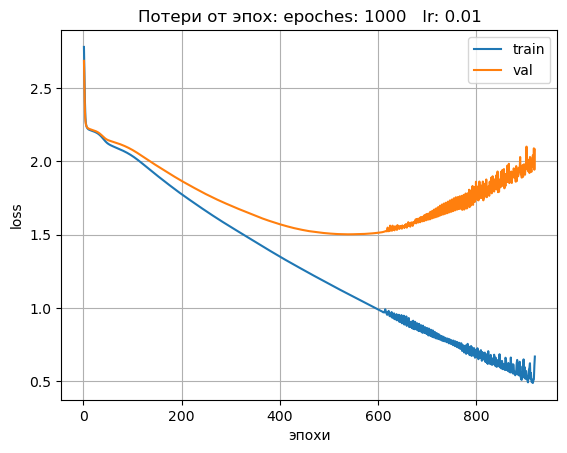

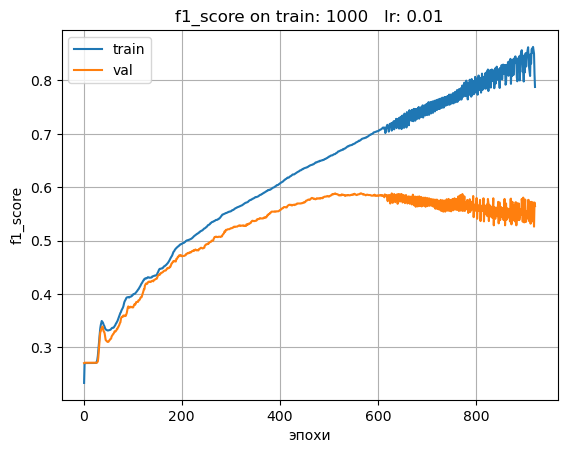

In [40]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)


model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(256, 18)
)

model =\
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100
)

# Добавляем Dropuot

Epoch 1/5000, train loss: 2.556, val_loss: 2.583, train f1_score: 0.242, val f1_score: 0.271
Epoch 100/5000, train loss: 2.080, val_loss: 2.231, train f1_score: 0.349, val f1_score: 0.349
Epoch 200/5000, train loss: 2.002, val_loss: 2.135, train f1_score: 0.386, val f1_score: 0.409
Epoch 300/5000, train loss: 1.926, val_loss: 2.055, train f1_score: 0.427, val f1_score: 0.446
Epoch 400/5000, train loss: 1.873, val_loss: 2.002, train f1_score: 0.445, val f1_score: 0.465
Epoch 500/5000, train loss: 1.838, val_loss: 1.965, train f1_score: 0.453, val f1_score: 0.474
Epoch 600/5000, train loss: 1.820, val_loss: 1.932, train f1_score: 0.457, val f1_score: 0.482
Epoch 700/5000, train loss: 1.799, val_loss: 1.904, train f1_score: 0.460, val f1_score: 0.490
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 798 эпохе пришлось остановить обучение
loss_798_эпохи >= loss_698_эпохи


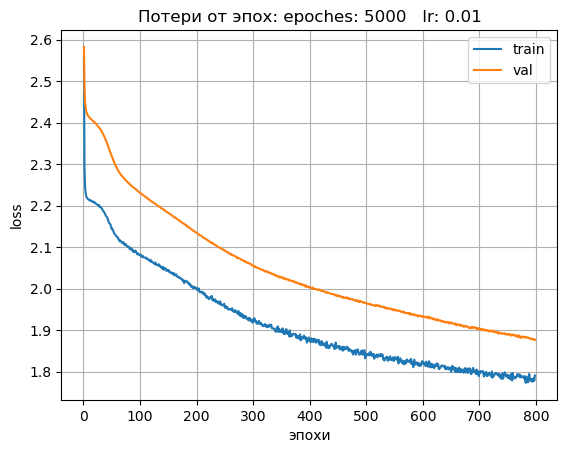

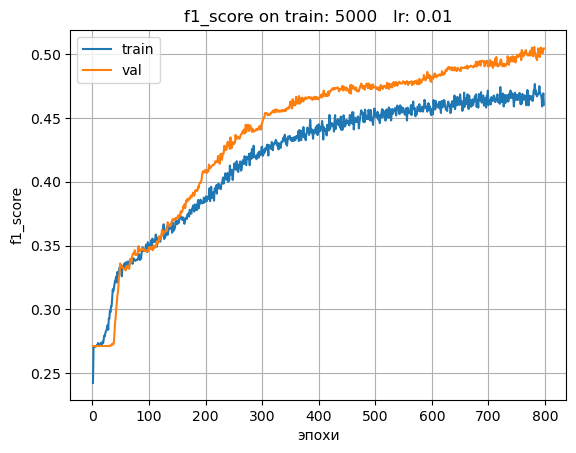

In [46]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    # nn.ELU(),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    # nn.ELU(),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 18)
)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100
)


Epoch 1/5000, train loss: 2.271, val_loss: 2.419, train f1_score: 0.267, val f1_score: 0.271
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 289 эпохе пришлось остановить обучение
loss_189_эпохи - loss_289_эпохи < 0.001


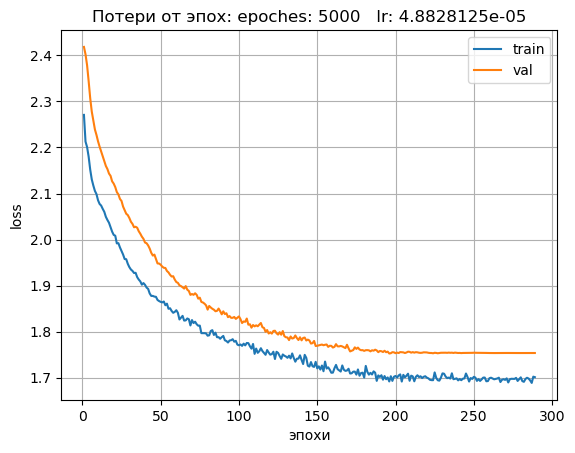

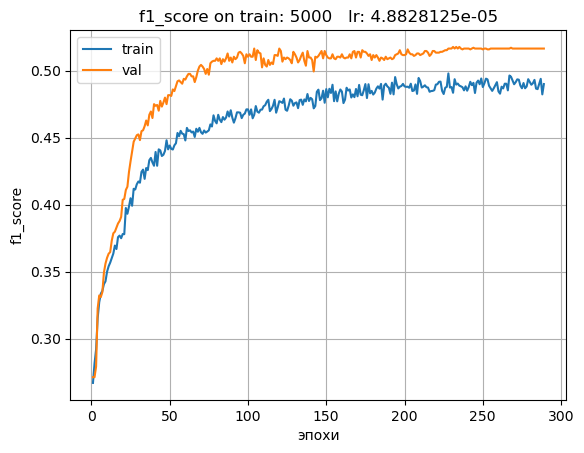

In [62]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    # nn.ELU(),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    # nn.ELU(),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 10, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Добавляем слои

Epoch 1/5000, train loss: 2.405, val_loss: 2.638, train f1_score: 0.265, val f1_score: 0.271
Epoch 300/5000, train loss: 1.889, val_loss: 2.117, train f1_score: 0.436, val f1_score: 0.415
Epoch 600/5000, train loss: 1.719, val_loss: 1.882, train f1_score: 0.486, val f1_score: 0.501
Epoch 900/5000, train loss: 1.622, val_loss: 1.744, train f1_score: 0.508, val f1_score: 0.536
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 1196 эпохе пришлось остановить обучение
loss_1196_эпохи >= loss_1096_эпохи


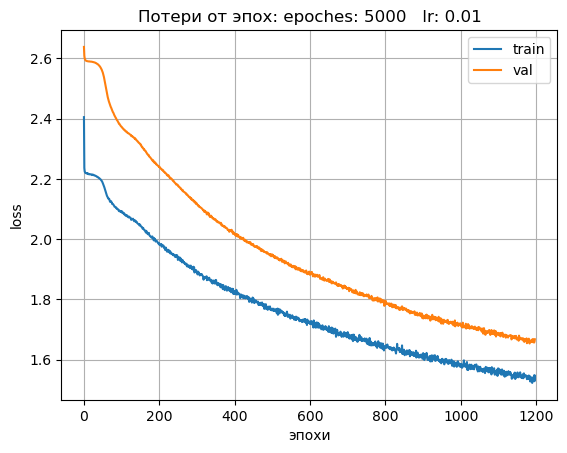

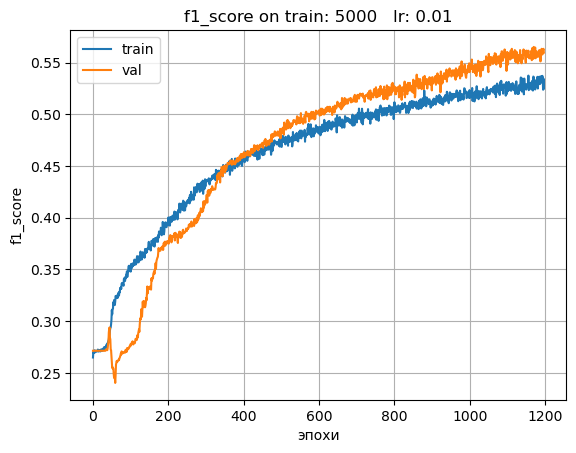

In [67]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Чередуем Dropout

Epoch 1/5000, train loss: 2.704, val_loss: 2.644, train f1_score: 0.218, val f1_score: 0.271
Epoch 300/5000, train loss: 1.956, val_loss: 2.015, train f1_score: 0.402, val f1_score: 0.408
Epoch 600/5000, train loss: 1.544, val_loss: 1.606, train f1_score: 0.548, val f1_score: 0.541
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 787 эпохе пришлось остановить обучение
loss_787_эпохи >= loss_687_эпохи


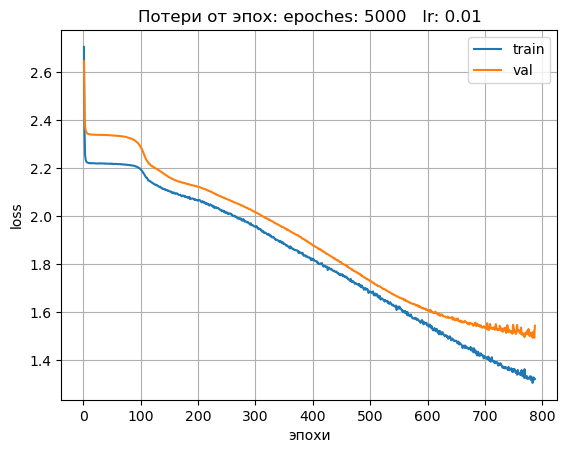

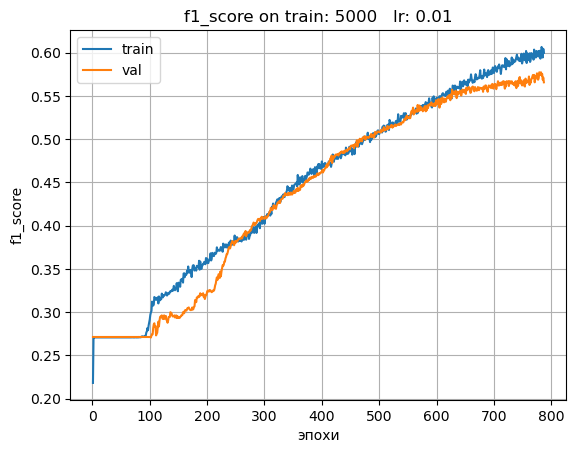

In [69]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Еще слои

Epoch 1/5000, train loss: 2.567, val_loss: 2.588, train f1_score: 0.264, val f1_score: 0.271
Epoch 300/5000, train loss: 1.766, val_loss: 1.970, train f1_score: 0.472, val f1_score: 0.457
Epoch 600/5000, train loss: 1.390, val_loss: 1.582, train f1_score: 0.579, val f1_score: 0.559
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 804 эпохе пришлось остановить обучение
loss_804_эпохи >= loss_704_эпохи


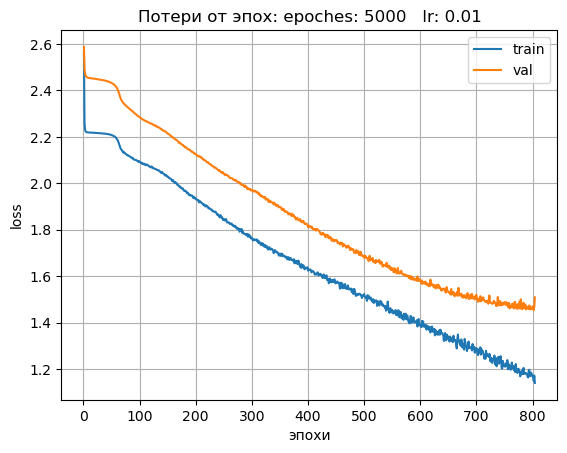

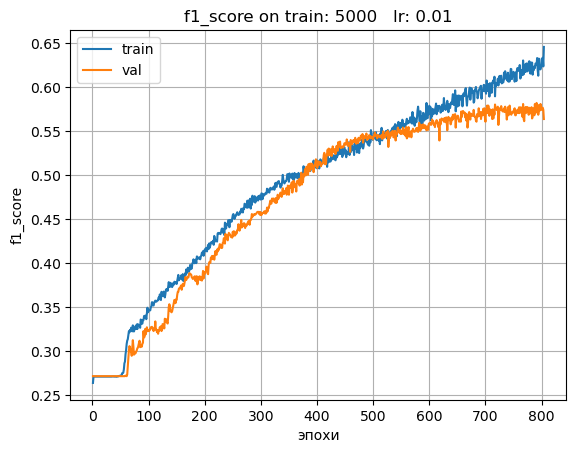

In [72]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Еще слои

Epoch 1/5000, train loss: 2.450, val_loss: 2.615, train f1_score: 0.266, val f1_score: 0.271
Epoch 300/5000, train loss: 1.817, val_loss: 2.156, train f1_score: 0.454, val f1_score: 0.373
Epoch 600/5000, train loss: 1.436, val_loss: 1.670, train f1_score: 0.560, val f1_score: 0.542
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 896 эпохе пришлось остановить обучение
loss_896_эпохи >= loss_796_эпохи


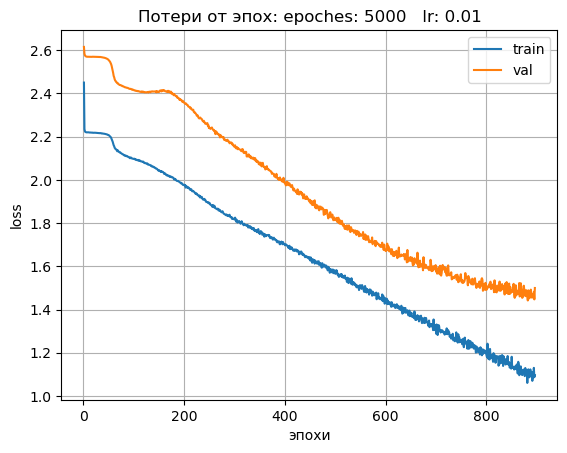

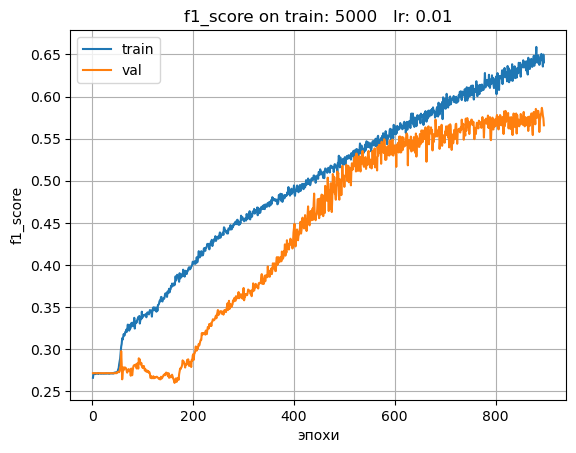

In [74]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    nn.ELU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(2048, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 164.332 минут
Epoch     1/ 5000 || time: 1.972 || train loss: 2.361, val_loss: 2.724, train f1_score: 0.264, val f1_score: 0.271
Epoch   300/ 5000 || time: 1.506 || train loss: 1.893, val_loss: 2.344, train f1_score: 0.431, val f1_score: 0.304
Epoch   600/ 5000 || time: 1.511 || train loss: 1.630, val_loss: 1.893, train f1_score: 0.509, val f1_score: 0.471
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 830 эпохе пришлось остановить обучение
loss_830_эпохи >= loss_780_эпохи


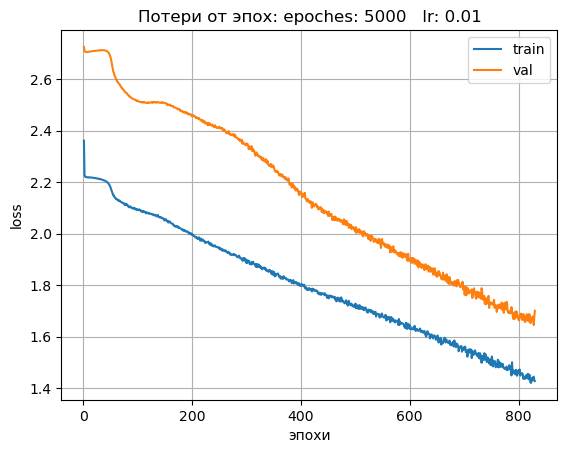

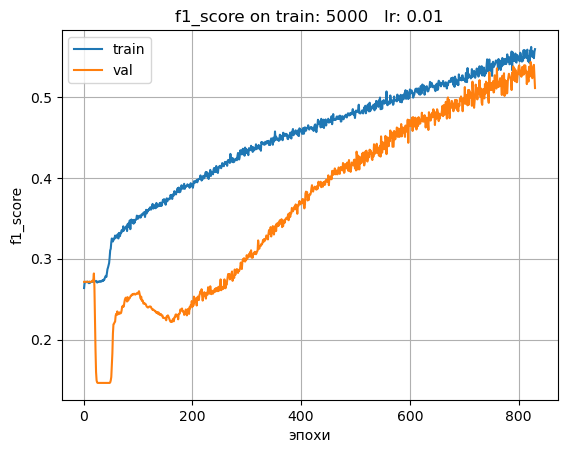

In [91]:
model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=3),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(2048, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.5, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 50,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 93.525 минут
Epoch     1/ 5000 || time: 1.122 || train loss: 3.519 || val_loss: 2.804 || train f1_score: 0.226 || val f1_score: 0.271
Epoch   300/ 5000 || time: 1.131 || train loss: 2.304 || val_loss: 1.992 || train f1_score: 0.414 || val f1_score: 0.400
Epoch   600/ 5000 || time: 1.077 || train loss: 1.939 || val_loss: 1.848 || train f1_score: 0.503 || val f1_score: 0.472
Epoch   900/ 5000 || time: 1.080 || train loss: 1.708 || val_loss: 1.719 || train f1_score: 0.556 || val f1_score: 0.520
Epoch  1200/ 5000 || time: 0.884 || train loss: 1.555 || val_loss: 1.638 || train f1_score: 0.595 || val f1_score: 0.543
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 1402 эпохе пришлось остановить обучение
loss_1402_эпохи >= loss_1202_эпохи


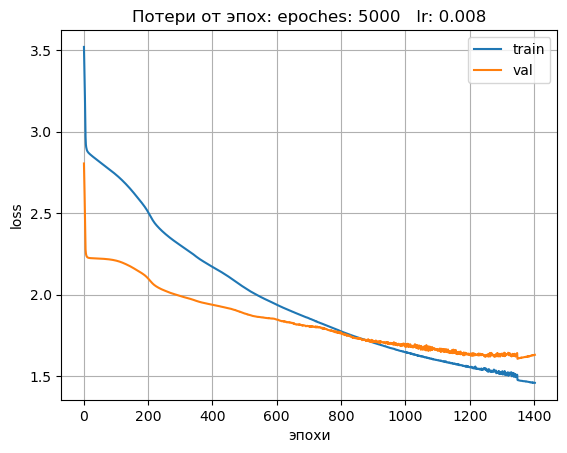

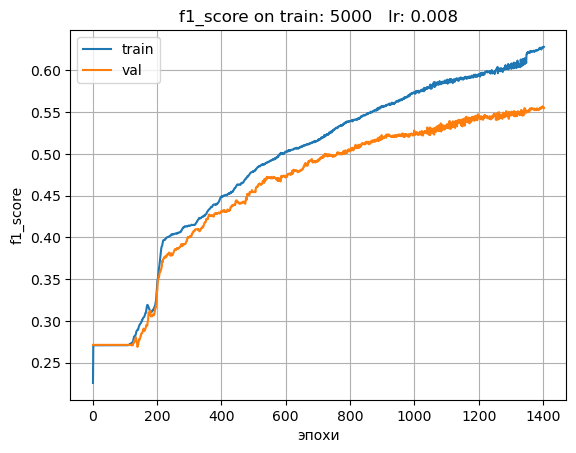

In [18]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3, padding = 1),
    nn.ReLU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
    nn.ReLU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
    nn.ReLU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
    nn.ReLU(),
    # nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1),
    nn.ReLU(),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 104.497 минут
Epoch     1/ 5000 || time: 1.254 || train loss: 3.309 || val_loss: 2.704 || train f1_score: 0.258 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.894 || train loss: 2.380 || val_loss: 2.359 || train f1_score: 0.353 || val f1_score: 0.272
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 460 эпохе пришлось остановить обучение
loss_460_эпохи >= loss_260_эпохи


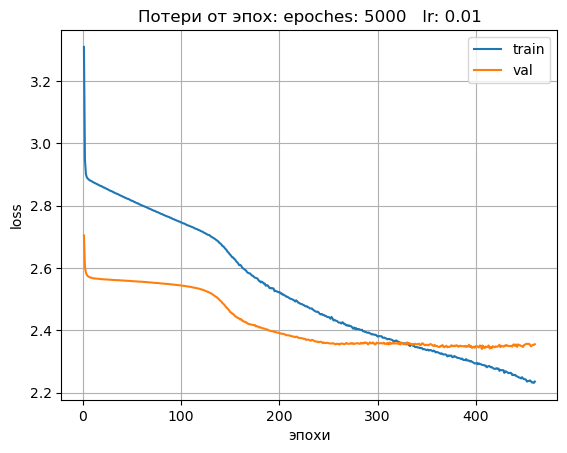

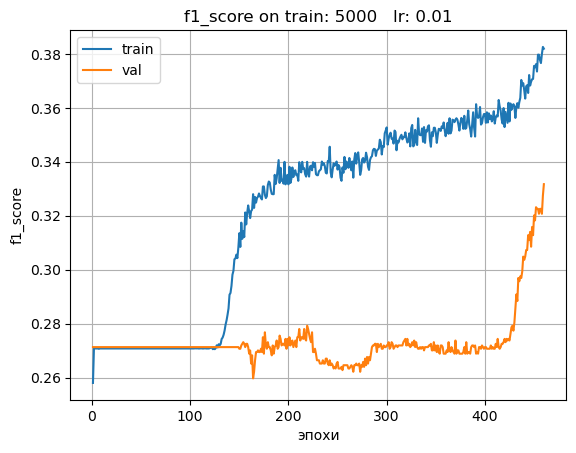

In [19]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 93.255 минут
Epoch     1/ 5000 || time: 1.119 || train loss: 3.056 || val_loss: 2.688 || train f1_score: 0.267 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.856 || train loss: 2.375 || val_loss: 2.296 || train f1_score: 0.362 || val f1_score: 0.309
Epoch   600/ 5000 || time: 0.844 || train loss: 2.137 || val_loss: 2.185 || train f1_score: 0.410 || val f1_score: 0.339
Epoch   900/ 5000 || time: 0.892 || train loss: 1.957 || val_loss: 2.046 || train f1_score: 0.451 || val f1_score: 0.405
Epoch  1200/ 5000 || time: 0.859 || train loss: 1.851 || val_loss: 1.962 || train f1_score: 0.479 || val f1_score: 0.457
Epoch  1500/ 5000 || time: 0.886 || train loss: 1.773 || val_loss: 1.868 || train f1_score: 0.501 || val f1_score: 0.493
Epoch  1800/ 5000 || time: 0.886 || train loss: 1.732 || val_loss: 1.775 || train f1_score: 0.517 || val f1_score: 0.514
Epoch  2100/ 5000 || time: 0.919 || train loss: 1.675 || val_loss: 1.696 || train f1_score: 0.536 || 

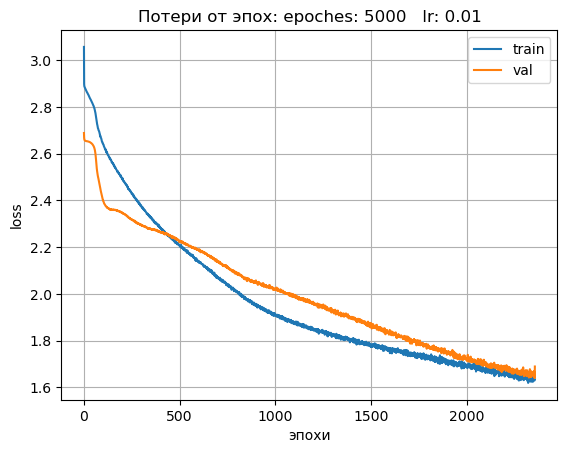

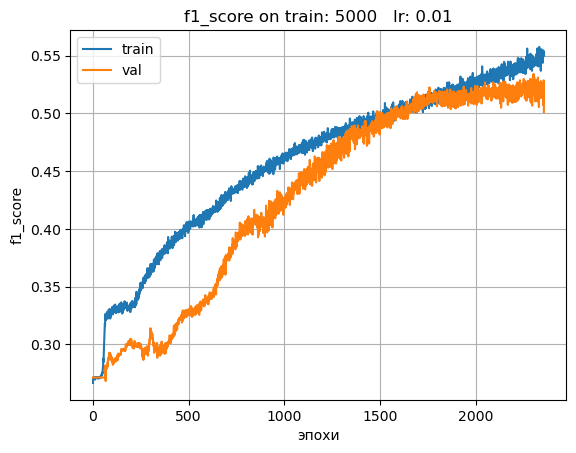

In [21]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 180.130 минут
Epoch     1/ 5000 || time: 2.162 || train loss: 3.704 || val_loss: 2.725 || train f1_score: 0.266 || val f1_score: 0.271
Epoch   300/ 5000 || time: 1.875 || train loss: 2.712 || val_loss: 2.319 || train f1_score: 0.362 || val f1_score: 0.271
Epoch   600/ 5000 || time: 1.763 || train loss: 2.281 || val_loss: 2.208 || train f1_score: 0.421 || val f1_score: 0.348
Epoch   900/ 5000 || time: 1.767 || train loss: 1.999 || val_loss: 2.008 || train f1_score: 0.458 || val f1_score: 0.427
Epoch  1200/ 5000 || time: 1.846 || train loss: 1.826 || val_loss: 1.846 || train f1_score: 0.493 || val f1_score: 0.485
Epoch  1500/ 5000 || time: 3.725 || train loss: 1.695 || val_loss: 1.730 || train f1_score: 0.529 || val f1_score: 0.504
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 1690 эпохе пришлось остановить обучение
loss_1690_эпохи >= loss_1490_эпохи


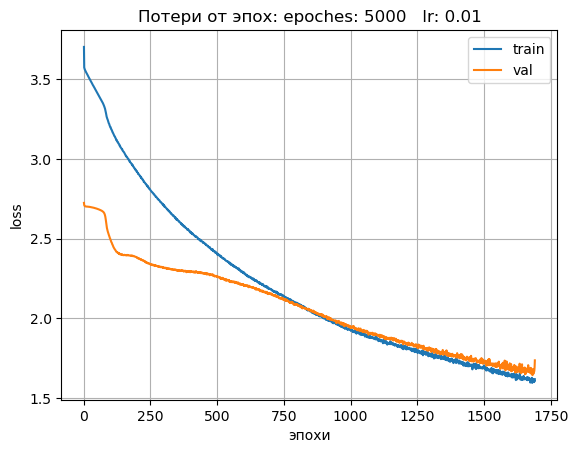

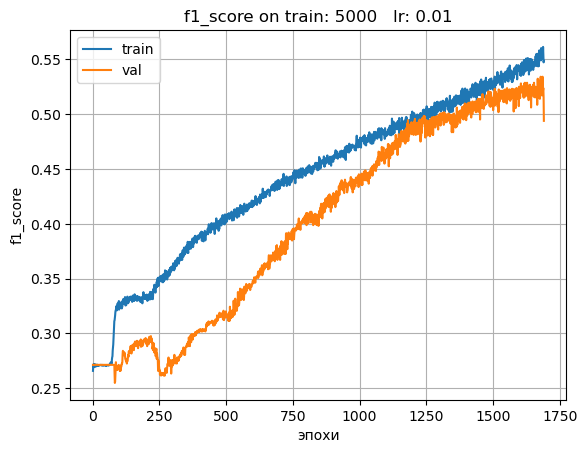

In [23]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=3, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(2048, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Kernel 3 ----> 5

Расчетное время выполнения всего цикла 253.837 минут
Epoch     1/ 5000 || time: 3.046 || train loss: 3.745 || val_loss: 2.686 || train f1_score: 0.268 || val f1_score: 0.271
Epoch   300/ 5000 || time: 2.014 || train loss: 2.494 || val_loss: 2.103 || train f1_score: 0.455 || val f1_score: 0.407
Epoch   600/ 5000 || time: 1.923 || train loss: 1.789 || val_loss: 1.560 || train f1_score: 0.581 || val f1_score: 0.562
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 787 эпохе пришлось остановить обучение
loss_787_эпохи >= loss_587_эпохи


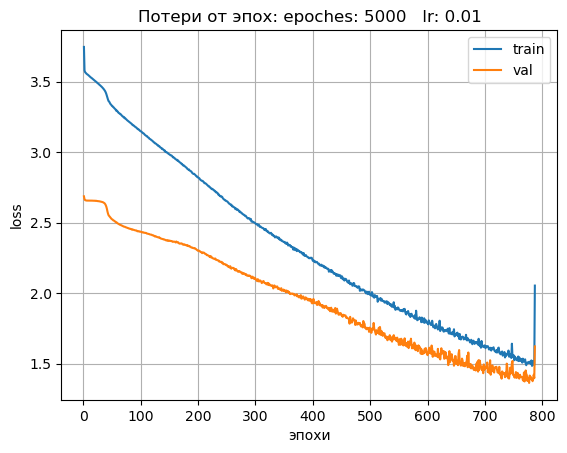

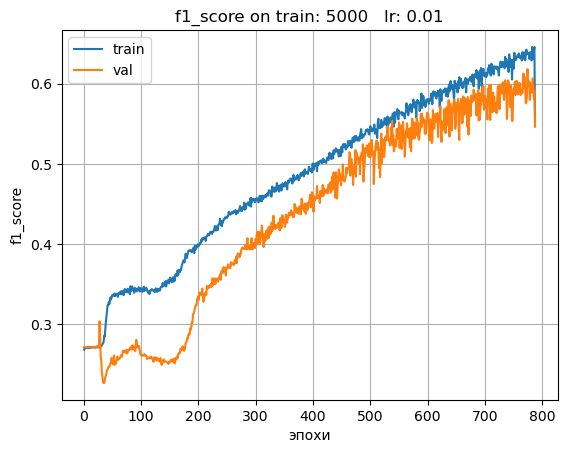

In [11]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(2048, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Maxpool1d

Расчетное время выполнения всего цикла 63.429 минут
Epoch     1/ 5000 || time: 0.761 || train loss: 2.692 || val_loss: 2.620 || train f1_score: 0.270 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.569 || train loss: 1.909 || val_loss: 2.004 || train f1_score: 0.469 || val f1_score: 0.460
Epoch   600/ 5000 || time: 0.569 || train loss: 1.733 || val_loss: 1.779 || train f1_score: 0.535 || val f1_score: 0.562
Epoch   900/ 5000 || time: 0.575 || train loss: 1.654 || val_loss: 1.657 || train f1_score: 0.568 || val f1_score: 0.582
Epoch  1200/ 5000 || time: 0.570 || train loss: 1.619 || val_loss: 1.584 || train f1_score: 0.580 || val f1_score: 0.596
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 1348 эпохе пришлось остановить обучение
loss_1348_эпохи >= loss_1148_эпохи


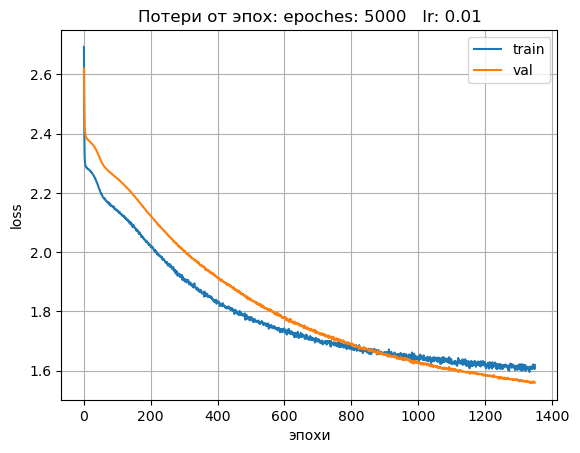

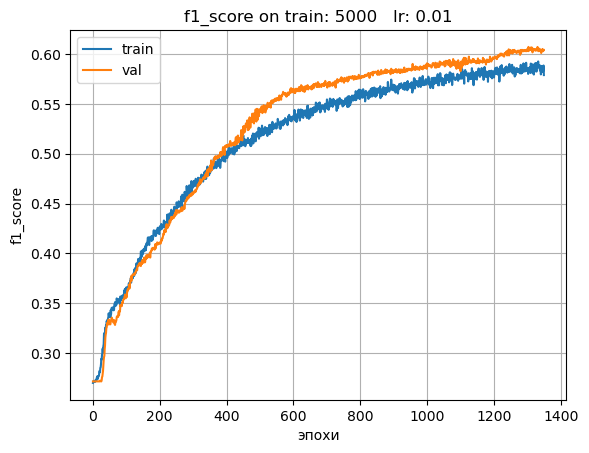

In [22]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 70.392 минут
Epoch     1/ 5000 || time: 0.845 || train loss: 2.824 || val_loss: 2.630 || train f1_score: 0.236 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.666 || train loss: 1.839 || val_loss: 1.797 || train f1_score: 0.509 || val f1_score: 0.517
Epoch   600/ 5000 || time: 0.562 || train loss: 1.524 || val_loss: 1.397 || train f1_score: 0.600 || val f1_score: 0.613
Epoch   900/ 5000 || time: 0.601 || train loss: 1.363 || val_loss: 1.189 || train f1_score: 0.659 || val f1_score: 0.665
Epoch  1200/ 5000 || time: 0.633 || train loss: 1.283 || val_loss: 1.092 || train f1_score: 0.691 || val f1_score: 0.682
Epoch  1500/ 5000 || time: 0.582 || train loss: 1.245 || val_loss: 1.043 || train f1_score: 0.702 || val f1_score: 0.690
________________________Ранняя остановка (тренировочные проблемы)_________________________________________________
На 1549 эпохе пришлось остановить обучение
loss_1349_эпохи - loss_1549_эпохи < 0.001


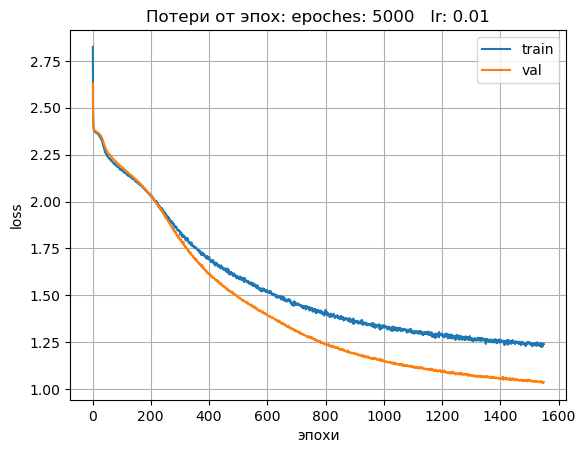

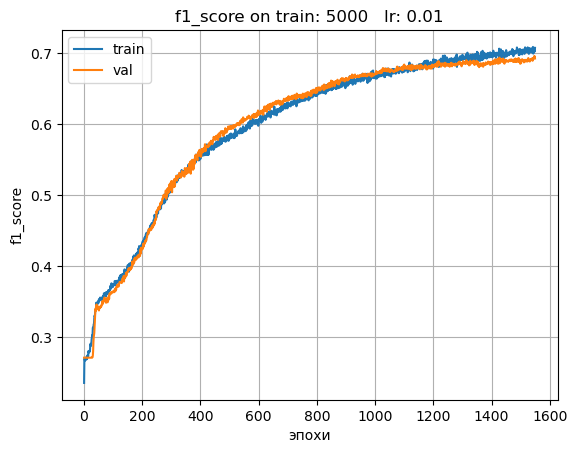

In [24]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(256, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 75.927 минут
Epoch     1/ 5000 || time: 0.911 || train loss: 3.122 || val_loss: 2.718 || train f1_score: 0.225 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.636 || train loss: 1.835 || val_loss: 1.599 || train f1_score: 0.532 || val f1_score: 0.547
Epoch   600/ 5000 || time: 0.618 || train loss: 1.386 || val_loss: 1.201 || train f1_score: 0.654 || val f1_score: 0.650
Epoch   900/ 5000 || time: 0.612 || train loss: 1.201 || val_loss: 1.042 || train f1_score: 0.711 || val f1_score: 0.682
Epoch  1200/ 5000 || time: 0.622 || train loss: 1.108 || val_loss: 0.972 || train f1_score: 0.741 || val f1_score: 0.708
Epoch  1500/ 5000 || time: 0.687 || train loss: 1.065 || val_loss: 0.935 || train f1_score: 0.752 || val f1_score: 0.719
Epoch  1800/ 5000 || time: 0.616 || train loss: 1.034 || val_loss: 0.920 || train f1_score: 0.769 || val f1_score: 0.725
________________________Ранняя остановка (тренировочные проблемы)____________________________________

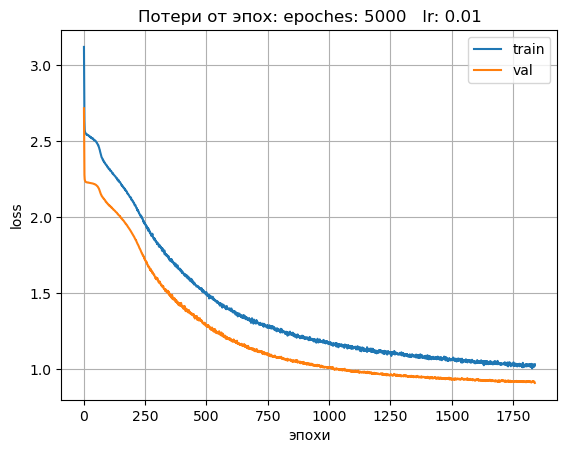

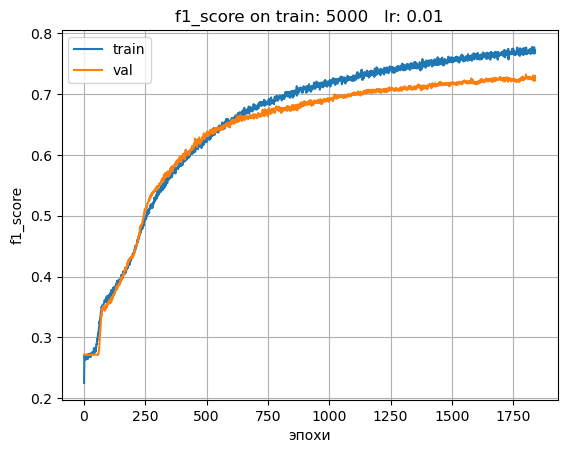

In [86]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 1),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 1),
    nn.ELU(),
    # nn.MaxPool1d(2),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 62.458 минут
Epoch     1/ 5000 || time: 0.749 || train loss: 3.063 || val_loss: 2.669 || train f1_score: 0.239 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.752 || train loss: 1.904 || val_loss: 1.768 || train f1_score: 0.505 || val f1_score: 0.501
Epoch   600/ 5000 || time: 0.705 || train loss: 1.436 || val_loss: 1.261 || train f1_score: 0.641 || val f1_score: 0.635
Epoch   900/ 5000 || time: 0.722 || train loss: 1.266 || val_loss: 1.079 || train f1_score: 0.688 || val f1_score: 0.682
Epoch  1200/ 5000 || time: 0.697 || train loss: 1.150 || val_loss: 1.000 || train f1_score: 0.728 || val f1_score: 0.704
Epoch  1500/ 5000 || time: 0.715 || train loss: 1.093 || val_loss: 0.954 || train f1_score: 0.748 || val f1_score: 0.715
Epoch  1800/ 5000 || time: 0.720 || train loss: 1.051 || val_loss: 0.929 || train f1_score: 0.763 || val f1_score: 0.725
________________________Ранняя остановка (валидационные проблемы)____________________________________

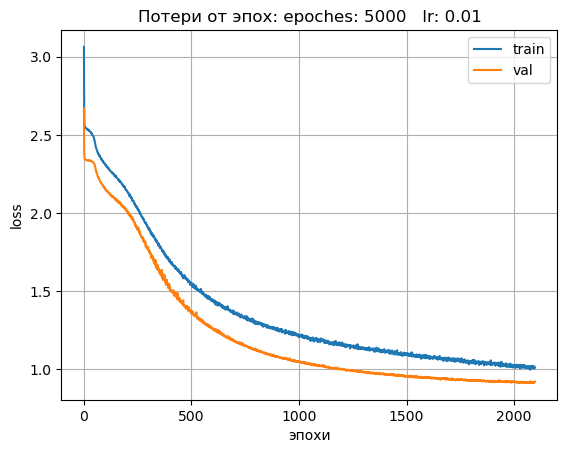

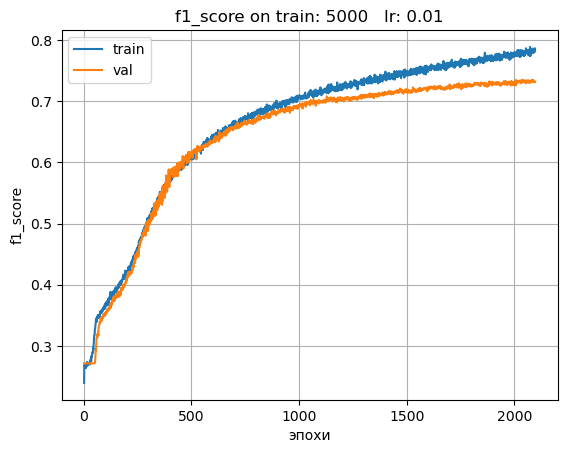

In [107]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 140.089 минут
Epoch     1/ 5000 || time: 1.681 || train loss: 3.495 || val_loss: 2.778 || train f1_score: 0.233 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.732 || train loss: 2.213 || val_loss: 1.936 || train f1_score: 0.447 || val f1_score: 0.432
Epoch   600/ 5000 || time: 1.010 || train loss: 1.596 || val_loss: 1.351 || train f1_score: 0.613 || val f1_score: 0.611
Epoch   900/ 5000 || time: 0.942 || train loss: 1.325 || val_loss: 1.108 || train f1_score: 0.680 || val f1_score: 0.674
Epoch  1200/ 5000 || time: 0.901 || train loss: 1.192 || val_loss: 1.016 || train f1_score: 0.720 || val f1_score: 0.705
Epoch  1500/ 5000 || time: 0.956 || train loss: 1.094 || val_loss: 0.950 || train f1_score: 0.744 || val f1_score: 0.721
Epoch  1800/ 5000 || time: 0.996 || train loss: 1.045 || val_loss: 0.923 || train f1_score: 0.765 || val f1_score: 0.729
________________________Ранняя остановка (валидационные проблемы)___________________________________

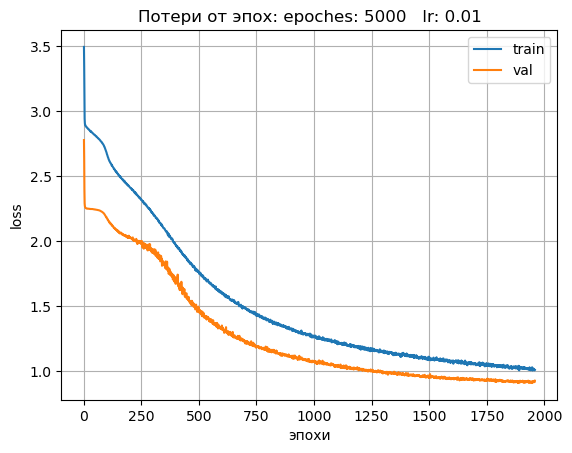

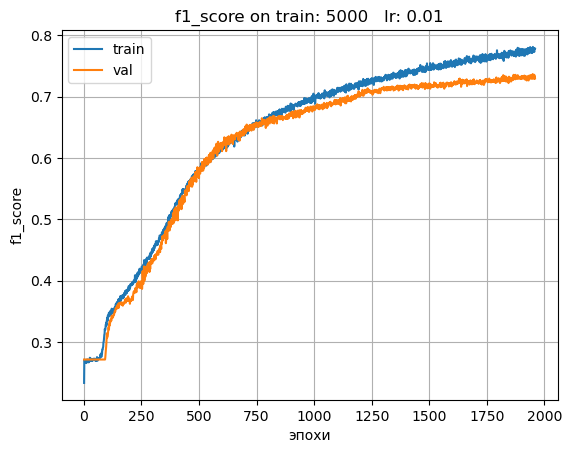

In [12]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    # nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=5, padding = 1),
    # nn.ELU(),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


Расчетное время выполнения всего цикла 105.616 минут
Epoch     1/ 5000 || time: 1.267 || train loss: 3.016 || val_loss: 2.274 || train f1_score: 0.263 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.862 || train loss: 1.044 || val_loss: 0.934 || train f1_score: 0.803 || val f1_score: 0.727
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 326 эпохе пришлось остановить обучение
loss_326_эпохи >= loss_126_эпохи


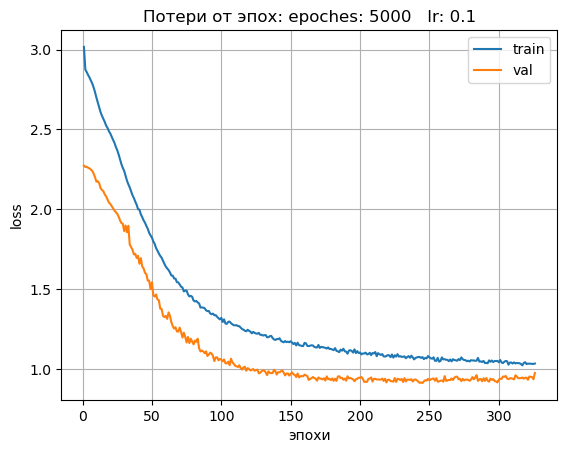

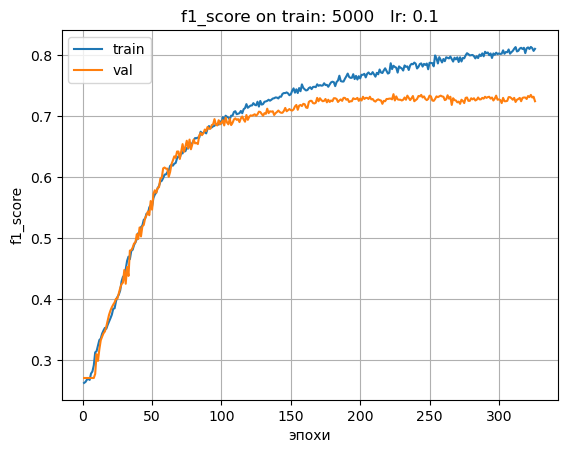

     train_loss  val_loss  f1_train   f1_test
223    1.072766  0.922380  0.782422  0.735976
243    1.071125  0.917570  0.786328  0.734756
322    1.034913  0.952681  0.813281  0.734756
262    1.059218  0.929348  0.795443  0.734146
249    1.074779  0.930416  0.787370  0.733537


In [12]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)


# Тренировка итоговой модели с сохранением паметров на каждой эпохе

In [105]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_test_list = []
    f1_score_train = []
    f1_score_test = []

    model = model.cuda()

    ################ Подготовка матрицы всех меток train / val наборов (для f1_score) #################
    all_labels_train = torch.tensor(())
    for _, labels in train_dataloader:
        all_labels_train = torch.concat([all_labels_train, labels])

    all_labels_test = torch.tensor(())
    for _, labels in val_dataloader:
        all_labels_test = torch.concat([all_labels_test, labels])
    ####################################################################################################

    for epoch in range(1, epoches+1):
            start_time = time.time()
            loss_train = 0
            loss_test = 0
            all_outputs_train = torch.tensor([]).to(device)
            all_outputs_test = torch.tensor([]).to(device)

            for features, labels in train_dataloader:
                
                model.train()
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(model = model,
                                                            type = reg_type,
                                                            l_lambda = 0.001,
                                                            loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                all_outputs_train = torch.concat([all_outputs_train, outputs], dim = 0)
            
            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
                
            ######## Расчет метрики на тренировочном наборе #####
            f1_score_train, f1_score_to_list_train =\
            f1_score_pytorch(outputs = all_outputs_train,
                             num_classes = 18,
                             all_labels = all_labels_train,
                             list_to_append = f1_score_train)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.cuda()
                                        labels = labels.cuda()
                                        outputs = model(features)
                                        loss_on_test = loss_fn(outputs, labels)
                                        loss_test += loss_on_test.item()

                                        all_outputs_test = torch.concat([all_outputs_test, outputs], dim = 0)

                                mean_epoch_loss_test = loss_test / len(val_dataloader)
                                loss_test_list.append(mean_epoch_loss_test)

                                ######## Расчет метрики на валидационном наборе #####
                                f1_score_test, f1_score_to_list_test =\
                                f1_score_pytorch(outputs = all_outputs_test,
                                                 num_classes = 18,
                                                 all_labels =  all_labels_test,
                                                 list_to_append = f1_score_test)
                                ######################################################
            # EARLY STOPPING #######################################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):

                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (тренировочные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                if len(loss_test_list) >= each__X__epoch:
                        past = loss_test_list[-each__X__epoch]
                        now = loss_test_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка (валидационные проблемы)_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
            torch.save(model, 'model_epoch_params/epoch_{}_model.pth'.format(epoch))
            ##############################################################
            scheduler.step(mean_epoch_loss_test)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train f1_score: {:.3f} || val f1_score: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_test,
                                f1_score_to_list_train,
                                f1_score_to_list_test
                                )     
                      )
            ################################################################
    
    result = pd.DataFrame([np.arange(1, epoch+1),loss_train_list, loss_test_list, f1_score_train, f1_score_test]).T
    result.columns = ['epoch', 'train_loss', 'val_loss', 'f1_train', 'f1_val']
    result = result.sort_values(by = 'f1_val',
                                ascending = False)
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_test_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                            optimizer.param_groups[0]['lr']))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_train,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_test,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('f1_score')
    plt.title('f1_score on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()
    print(result.head())
    
    return model, result

Расчетное время выполнения всего цикла 84.996 минут
Epoch     1/ 5000 || time: 1.020 || train loss: 3.040 || val_loss: 2.261 || train f1_score: 0.263 || val f1_score: 0.271
Epoch   300/ 5000 || time: 0.990 || train loss: 1.042 || val_loss: 0.937 || train f1_score: 0.803 || val f1_score: 0.729
________________________Ранняя остановка (валидационные проблемы)_________________________________________________
На 341 эпохе пришлось остановить обучение
loss_341_эпохи >= loss_141_эпохи


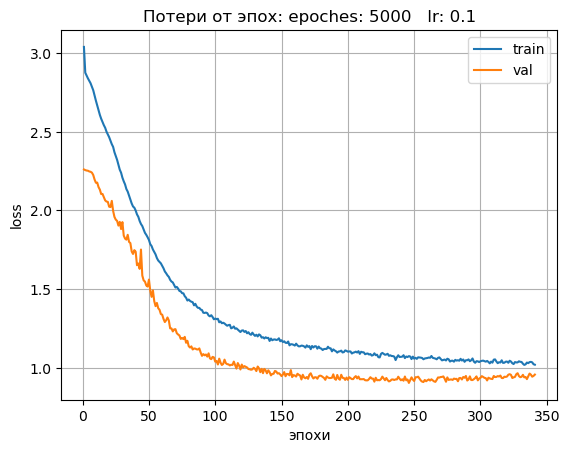

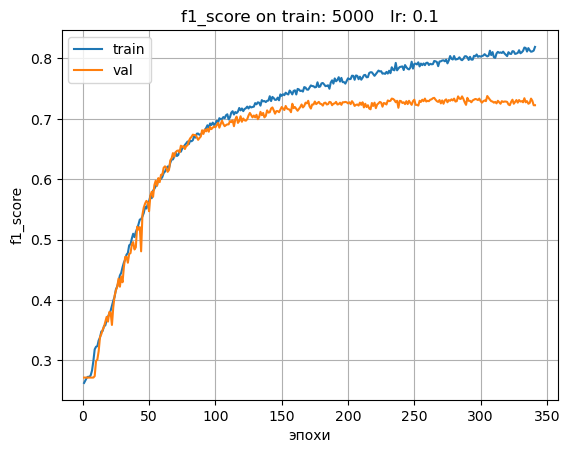

     epoch  train_loss  val_loss  f1_train    f1_val
304  305.0    1.043810  0.919819  0.803516  0.737805
282  283.0    1.048557  0.914826  0.799479  0.737195
285  286.0    1.046295  0.925990  0.797135  0.737195
264  265.0    1.061416  0.913833  0.795833  0.734756
305  306.0    1.037439  0.937336  0.804557  0.734756


In [106]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     частота_символа_в_фрейме_для_удаления = 2),
                            batch_size = 128,
                            shuffle = False)

model = nn.Sequential(
    nn.Conv1d(in_channels=17, out_channels=64, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=5, padding = 2),
    nn.ELU(),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(1024, 18)
)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 100, factor=0.8, threshold=0.001, verbose=True)

model, result =\
training_loop(
    epoches = 5000,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 200,
    stop_diff_value = 0.001,
    verbose_epoch = 300
)

In [118]:
test_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'test',
                                                       частота_символа_в_фрейме_для_удаления = 2),
                              batch_size = 128,
                              shuffle = False)


all_labels_test = torch.tensor(())
all_features_test = torch.tensor(())

for features, labels in test_dataloader:
        all_labels_test = torch.concat([all_labels_test, torch.tensor(labels)])
        all_features_test = torch.concat([all_features_test, torch.tensor(features)])

In [113]:
result = result[(result['epoch'] >= 100) & (result['epoch'] <= 120)]
result['diff'] = result['f1_train'] - result['f1_val']

In [115]:
result.sort_values(by = 'diff')

,epoch,train_loss,val_loss,f1_train,f1_val,diff
101,102.0,1.311757,1.021277,0.692969,0.693293,-0.000324
104,105.0,1.283455,1.018071,0.699870,0.696951,0.002919
115,116.0,1.251027,0.995208,0.709505,0.703659,0.005847
99,100.0,1.313264,1.038994,0.692318,0.685976,0.006342
110,111.0,1.273292,1.015372,0.702734,0.696341,0.006393
100,101.0,1.309507,1.044205,0.696615,0.689634,0.006980
103,104.0,1.294680,1.032655,0.699219,0.691463,0.007755
109,110.0,1.271715,1.022081,0.699089,0.690854,0.008235
118,119.0,1.227581,0.989597,0.714063,0.704268,0.009794
105,106.0,1.286764,1.024916,0.702995,0.691463,0.011531


Выбираем 102 эпоху. И скачиваем веса модели на этой эпохе

In [125]:
model = torch.load('model_epoch_params/epoch_102_model.pth')

In [127]:
outputs = model(all_features_test.to(device))
outputs

tensor([[ 6.5239, -4.0604,  0.3238,  ..., -1.2263,  1.2638, -2.7508],
        [ 6.5752, -2.8970,  1.3481,  ..., -1.9245,  0.5764, -2.9068],
        [ 7.6200, -2.7324,  0.7966,  ..., -1.6633,  0.8921, -2.4537],
        ...,
        [-5.2686,  4.3300, -0.2729,  ..., -0.6275, -0.0456,  2.2903],
        [-3.4997,  3.2696,  0.2832,  ..., -1.2086,  0.2732,  1.8782],
        [ 1.5504,  3.6826,  0.1118,  ..., -2.4520,  0.1793,  1.6777]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [131]:
_, predict = torch.max(torch.softmax(outputs, dim = 1), dim = 1)
y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
f1_score_test = \
f1_score(y_true = all_labels_test,
         y_pred = y_pred.cpu().detach().numpy(),
         average = 'micro')

f1_score_test

0.7006024096385542

# Вывод

- Только слои Conv1d (с геометрической прогрессией кол-ва нейронов) с активациями не дают максимальную метрику
- Conv1d + Maxpool дают прирост в 7-10 процентов
- для данного набора наилучшей активацией является ELU



f1_score = 0.7 (такая же каки на тренировочных / валидационных выборках)